# Solving BS equation using NN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import linear, sigmoid, relu

In [ ]:
from sklearn.model_selection import train_test_split
from scipy.stats import norm

## This is a call option model, also we can use put option model or we can add another parameter to control

In [ ]:
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call

## we just build a solution set by ourselves, and the range can be adjusted.
## However, I think it is not allowed if we want to prove the BS equation is correct, we should use the real data to train the model instead just build one, but the structure is the same.
## Then we compute the loss between the data from our NN model and from BS equation to prove it correct

In [ ]:
# Generate synthetic data(change for the real data)
np.random.seed(42)
S = np.random.uniform(50, 150, 100000)  # Stock price
K = np.random.uniform(50, 150, 100000)  # Strike price
T = np.random.uniform(0.5, 2, 100000)   # Time to maturity
r = np.random.uniform(0.01, 0.05, 100000) # Risk-free rate
sigma = np.random.uniform(0.1, 0.4, 100000) # Volatility

# Black-Scholes prices
BS_prices = black_scholes(S, K, T, r, sigma)

# Prepare data for training
X = np.column_stack((S, K, T, r, sigma))
y = BS_prices

### we can do validation here if we want to consider other kind of NN models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### The model is here, parameters can be changed

In [ ]:
model = Sequential([
    tf.keras.Input(shape=(5,)),
    Dense(units=64, activation='relu',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(units=32, activation='relu',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(units=32, activation='relu',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(units=1, activation= 'linear',kernel_regularizer=tf.keras.regularizers.L2(0.001))
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3553 (13.88 KB)
Trainable params: 3553 (13.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


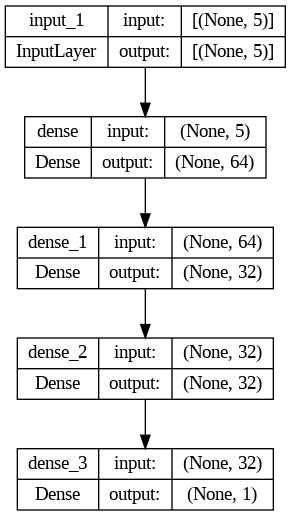

In [ ]:
from tensorflow.keras.utils import plot_model

# Generate a plot of your model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
model.fit(X_train, y_train, epochs=2000, batch_size=128, verbose=1)

Epoch 1/2000
625/625 [==============================] - 4s 2ms/step - loss: 84.7078
Epoch 2/2000
625/625 [==============================] - 1s 2ms/step - loss: 9.5971
Epoch 3/2000
625/625 [==============================] - 1s 2ms/step - loss: 8.8610
Epoch 4/2000
625/625 [==============================] - 2s 3ms/step - loss: 8.1364
Epoch 5/2000
625/625 [==============================] - 2s 3ms/step - loss: 7.2617
Epoch 6/2000
625/625 [==============================] - 1s 2ms/step - loss: 6.6612
Epoch 7/2000
625/625 [==============================] - 1s 2ms/step - loss: 5.8796
Epoch 8/2000
625/625 [==============================] - 1s 2ms/step - loss: 5.1191
Epoch 9/2000
625/625 [==============================] - 1s 2ms/step - loss: 4.4552
Epoch 10/2000
625/625 [==============================] - 1s 2ms/step - loss: 3.5553
Epoch 11/2000
625/625 [==============================] - 1s 2ms/step - loss: 3.0601
Epoch 12/2000
625/625 [==============================] - 1s 2ms/step - loss: 2.7919


In [ ]:
y_pred = model.predict(X_test)


625/625 [==============================] - 1s 1ms/step


### Report the loss here

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.09492514244654429


### We can try to reduce the loss further

### 1. Call Option price v.s Stock price, given K = 100, T = 1, r = 0.05, sigma = 0.2

In [ ]:
import seaborn as sns

### we can change the number here to change price range or other parameter we want

In [ ]:
X_S = [[i/10, 100, 1, 0.05, 0.2] for i in range(500,1500)]
X_S = np.array(X_S)


In [ ]:
pred_option_price = model.predict(X_S)

32/32 [==============================] - 0s 2ms/step


In [ ]:
Stock_price = X_S[:, 0]

In [ ]:

result = pd.DataFrame(np.column_stack((Stock_price, pred_option_price)),columns=['stock_price', 'option_price'])
result

,stock_price,option_price
0,50.0,-0.004674
1,50.1,-0.004547
2,50.2,-0.004420
3,50.3,-0.004292
4,50.4,-0.004165
...,...,...
995,149.5,53.897003
996,149.6,53.995125
997,149.7,54.093231
998,149.8,54.191353


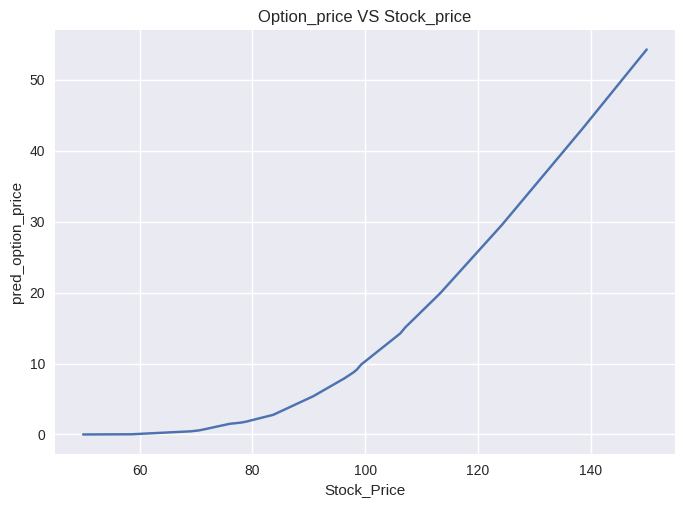

In [ ]:
%matplotlib inline
plt.style.use('seaborn')
plt.plot(Stock_price, pred_option_price)
plt.xlabel('Stock_Price')
plt.ylabel('pred_option_price')
plt.title('Option_price VS Stock_price')
plt.show()

### 2. Call Option price v.s Strike price, given S = 110, T = 1, r = 0.05, sigma = 0.2

In [ ]:
X_K = [[110, i/10, 1, 0.05, 0.2] for i in range(500,1500)]
X_K = np.array(X_K)

In [ ]:
pred_option_price = model.predict(X_K)

32/32 [==============================] - 0s 676us/step


In [ ]:
Strike_price = X_K[:, 1]

In [ ]:
result = pd.DataFrame(np.column_stack((Strike_price, pred_option_price)),columns=['strike_price', 'option_price'])
result

,strike_price,option_price
0,50.0,62.514484
1,50.1,62.419949
2,50.2,62.325420
3,50.3,62.230885
4,50.4,62.136349
...,...,...
995,149.5,1.691592
996,149.6,1.681894
997,149.7,1.672197
998,149.8,1.662499


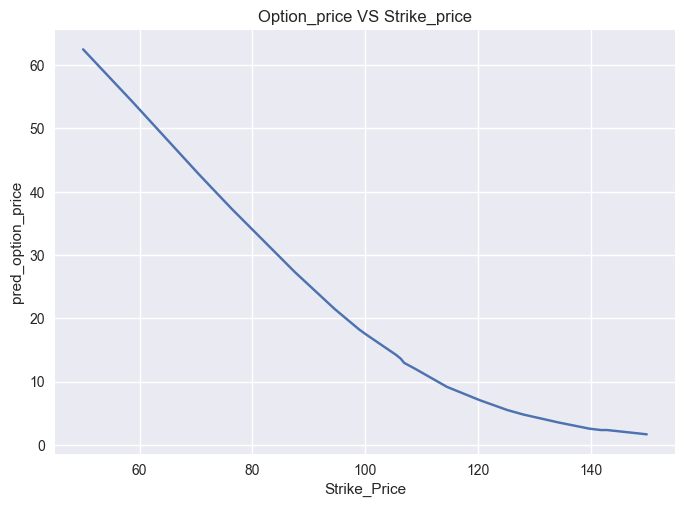

In [ ]:
plt.plot(Strike_price, pred_option_price)
plt.xlabel('Strike_Price')
plt.ylabel('pred_option_price')
plt.title('Option_price VS Strike_price')
plt.show()

### 3. Call Option price v.s Time, given K = 110, S = 120, r = 0.05, sigma = 0.2

In [ ]:
X_T = [[110, 120, i/100, 0.05, 0.2] for i in range(50,200)]
X_T = np.array(X_T)

In [ ]:
pred_option_price = model.predict(X_T)

5/5 [==============================] - 0s 996us/step


In [ ]:
Time = X_T[:, 2]

In [ ]:
result = pd.DataFrame(np.column_stack((Time, pred_option_price)),columns=['Time', 'option_price'])
result

,Time,option_price
0,0.50,3.793005
1,0.51,3.862293
2,0.52,3.931583
3,0.53,4.000874
4,0.54,4.070163
...,...,...
145,1.95,12.449830
146,1.96,12.487926
147,1.97,12.526017
148,1.98,12.564112


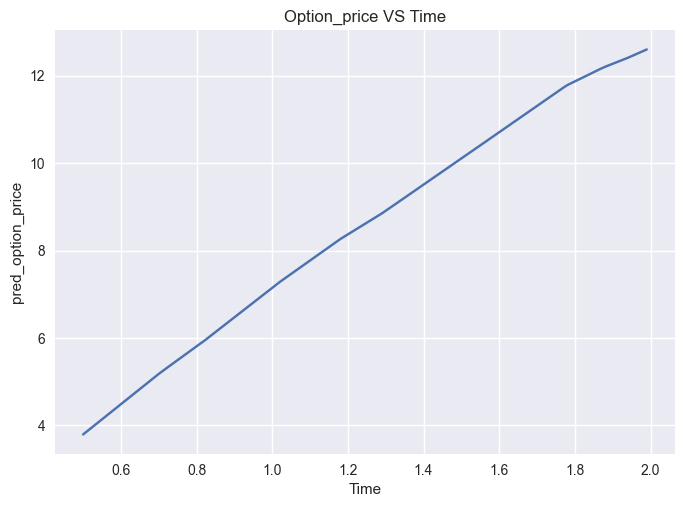

In [ ]:
plt.plot(Time, pred_option_price)
plt.xlabel('Time')
plt.ylabel('pred_option_price')
plt.title('Option_price VS Time')
plt.show()

### 4. Call Option price v.s Risk-free rate, given K = 110, S = 120, T = 1, sigma = 0.2

In [ ]:
X_r = [[110, 120, 1, i/10000, 0.2] for i in range(100,500)]
X_r = np.array(X_r)

In [ ]:
pred_option_price = model.predict(X_r)

13/13 [==============================] - 0s 832us/step


In [ ]:
Risk_free_rate = X_r[:, 3]

In [ ]:
result = pd.DataFrame(np.column_stack((Risk_free_rate, pred_option_price)),columns=['Risk_free_rate', 'option_price'])
result

,Risk_free_rate,option_price
0,0.0100,5.131674
1,0.0101,5.135933
2,0.0102,5.140187
3,0.0103,5.144444
4,0.0104,5.148700
...,...,...
395,0.0495,7.122324
396,0.0496,7.127512
397,0.0497,7.132702
398,0.0498,7.137890


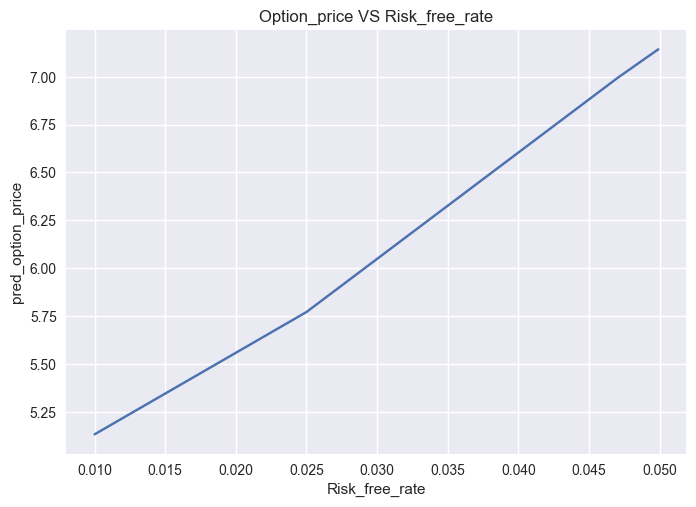

In [ ]:
plt.plot(Risk_free_rate, pred_option_price)
plt.xlabel('Risk_free_rate')
plt.ylabel('pred_option_price')
plt.title('Option_price VS Risk_free_rate')
plt.show()

### 5. Call Option price v.s Sigma, given K = 110, S = 120, T = 1, r = 0.05

In [ ]:
X_sigma = [[110, 120, 1, 0.05, i/1000] for i in range(100,400)]
X_sigma = np.array(X_sigma)

In [ ]:
pred_option_price = model.predict(X_sigma)

10/10 [==============================] - 0s 997us/step


In [ ]:
Sigma = X_sigma[:, 4]

In [ ]:
result = pd.DataFrame(np.column_stack((Sigma, pred_option_price)),columns=['Sigma', 'option_price'])
result

,Sigma,option_price
0,0.100,3.203280
1,0.101,3.239589
2,0.102,3.275898
3,0.103,3.312206
4,0.104,3.348517
...,...,...
295,0.395,15.337384
296,0.396,15.385269
297,0.397,15.433157
298,0.398,15.481041


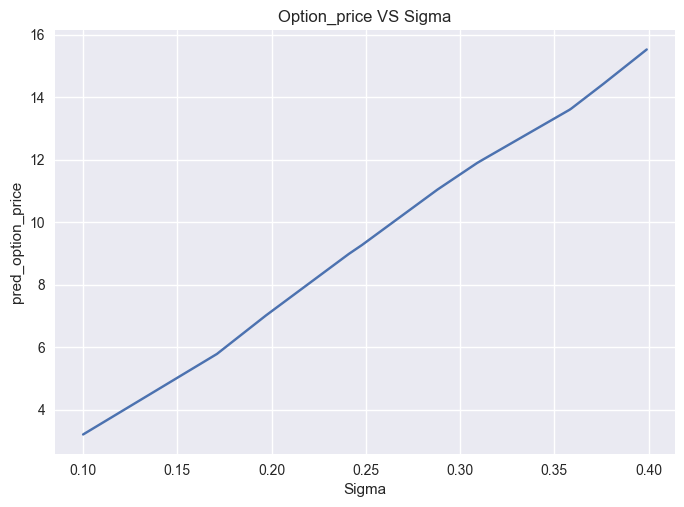

In [ ]:
plt.plot(Sigma, pred_option_price)
plt.xlabel('Sigma')
plt.ylabel('pred_option_price')
plt.title('Option_price VS Sigma')
plt.show()